In [10]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Week of 6/21
Start embedding your model understanding into computational frameworks. So as an exercise, take a stab at implementing the Hodgkin Huxley model for numerical solution, e.g. using scipy (odeint or newer methods).

## Hodgkin-Huxley Model

In [11]:
def plot_vnmh(x,t,vertIndex=-1,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')
    
    #Extract variables from matrix
    if x.shape[1] == 4:
        V = x[:,0]
        n = x[:,1]
        m = x[:,2]
        h = x[:,3]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V)
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n,label="n")
            plt.plot(t,m,label="m")
            plt.plot(t,h,label="h")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()
        
    elif x.shape[0] == 10:
        V1 = x[0]
        n1 = x[1]
        m1 = x[2]
        h1 = x[3]
        s1 = x[4]
        V2 = x[5]
        n2 = x[6]
        m2 = x[7]
        h2 = x[8]
        s2 = x[9]
            
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            plt.plot(t,n2,label="n2")
            plt.plot(t,m2,label="m2")
            plt.plot(t,h2,label="h2")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()

In [12]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h

    return dVdt, dndt, dmdt, dhdt

In [13]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [14]:
def burn_in(x0, t):
    '''
    Generates the initial conditions by starting at "accepted" values and then "burning in" until we have values with no temporal dependence
    
    Params: 
        x0: ICs for V,n,m,h
        t: time vector, not sure if this is actually needed (not called in func) 
    '''
    
    #By not specifying vI, vI is set to a vector of zeros, ie no applied current fr the burn in run
    x = odeint(odes,x0,t,args=(I,vI))
    print("Burn in plot: ensure that by end of time interval, the values have reached steady state")
    plot_vnmh(x,t)
    return x

def burn_in_scn(x0, t):
    #This needs to be updated to include vI_scn, as g is passed in through this vector in odes_scn
    '''
    Generates the initial conditions by starting at "accepted" values and then "burning in" until we have values with no temporal dependence
    
    Params: 
        x0: ICs for V,n,m,h
        t: time vector, not sure if this is actually needed (not called in func) 
    '''
    
    #By not specifying vI, vI is set to a vector of zeros, ie no applied current fr the burn in run
    x = odeint(odes_scn,x0,t,args=(I,vI))
    print("Burn in plot: ensure that by end of time interval, the values have reached steady state")
    plot_vnmh(x,t)
    return x

BURN IN: instead of using the random, clean x0 initial conditions I found, we should use burn in to find what the true steady state of our system is.  I.e. let it run for a really long time and whatever it equilibriates to is what we will use for "true" SS going forward:

Burn in plot: ensure that by end of time interval, the values have reached steady state


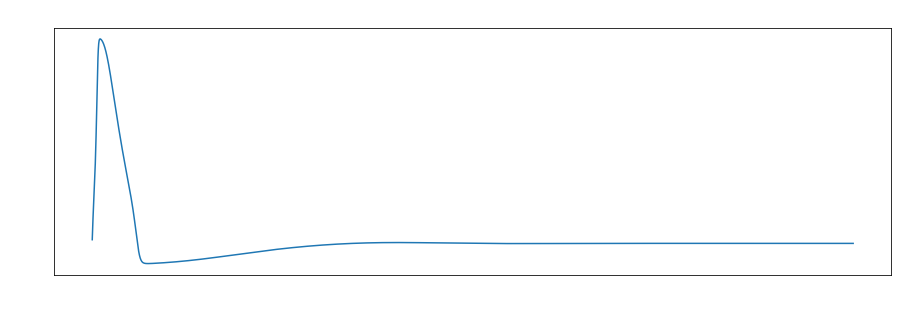

In [15]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = burn_in(x0, t) #odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

In [16]:
print("Comparing our original x0 to what our system of differntial equations seems to prefer as SS:")
print(x0)
x0_new = x[-1,:]
print(x0_new)

Comparing our original x0 to what our system of differntial equations seems to prefer as SS:
[-58, 0.05, 0.33, 0.6]
[-6.00470736e+01  3.16944630e-01  5.26385829e-02  5.97749949e-01]


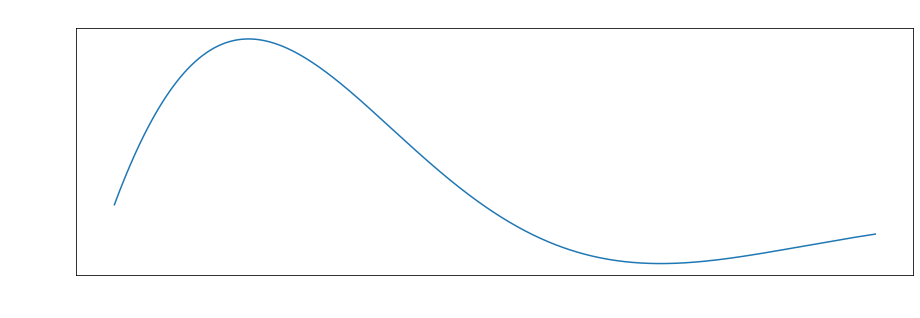

In [17]:
#BURNED IN initial condition
#time vector
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

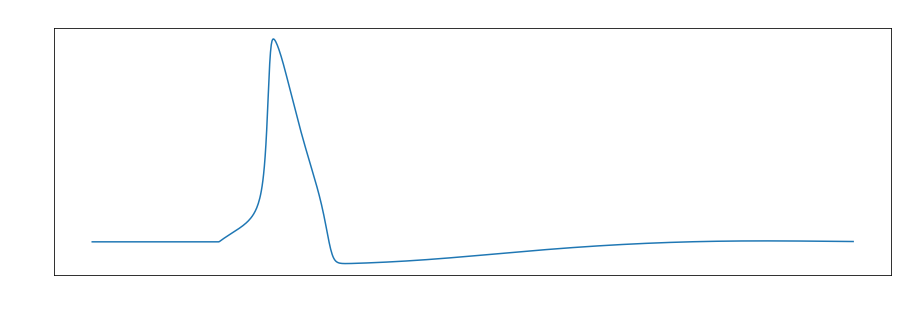

In [18]:
t = np.linspace(0,30,1000) #ms
#NOW SETTING vI to something realistic:
vI = [5,7,0.1]

x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

## Tasks Post 6/23 Meeting:
2. SYNAPTICALLY COUPLED NEURONS: Choose the reversal potential to be the same as the sodium current (Excitatory synapse)
3. Start with synpatic g of 0 to verify 
4. Then begin increasing both g's --> numerically find some minimal set of g's, FIND SUSTAINED OSCILLATION OF CONTINUOUS SPIKING

In [45]:
def odes_scn(x0,t,I,vI_scn):
    '''
    Defines the constants and differential equations for the HH-compliant synaptically coupled neurons.
    
    Params:: 
        x0: ICs for V1,n1,m1,h1,s1,V2,n2,m2,h2,s2
        t: time vector, not sure if this is actually needed (not called in func)
        I: custom function, time varying current (square wave)
        vI_scn: custom 5x1 vector for I function, just encapsulates the parameters needed for I to function.  
          Also encapsulates the values for g1 and g2
        
    Returns:: Differential equations of each variable as a vector
    
    '''
        
    #set ICs
    V1 = x0[0]
    n1 = x0[1]
    m1 = x0[2]
    h1 = x0[3]
    s1 = x0[4]
    
    V2 = x0[5]
    n2 = x0[6]
    m2 = x0[7]
    h2 = x0[8]
    s2 = x0[9]
        
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa1 = gbarNa*(m1**3)*h1
    gNa2 = gbarNa*(m2**3)*h2
    gbarK = 0.36 #mS/cm2
    gK1 = gbarK*(n1**4)
    gK2 = gbarK*(n2**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #Passing g1/g2 through vI might not be the best approach...
    gbars1 = vI_scn[3]
    gs1 = gbars1*s1
    gbars2 = vI_scn[4]
    gs2 = gbars2*s2
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    ES1 = ENa #0 #mV #Excitatory Neuron (by this definition)
    ES2 = ES1
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
        
    #NEURON1
    #Alpha and beta forms
    alpha_n1 = 0.01*(V1+50)/(1-np.exp(-(V1+50)/10))
    beta_n1 = 0.125*np.exp(-(V1+60)/80)
    alpha_m1 = 0.1*(V1+35)/(1-np.exp(-(V1+35)/10))
    beta_m1 = 4.0*np.exp(-0.0556*(V1+60))
    alpha_h1 = 0.07*np.exp(-0.05*(V1+60))
    beta_h1 = 1/(1+np.exp(-0.1*(V1+30)))
    #define each ODE                                        #NOTE: USE G OF S2 HERE, FOR EQN V1
    dV1dt = (1/Cm)*(gNa1*(ENa-V1) + gK1*(EK-V1) + gL*(EL-V1) + gs2*(ES2-V1) + I(t,vI_scn)) 
    dn1dt = alpha_n1*(1-n1)-beta_n1*n1
    dm1dt = alpha_m1*(1-m1)-beta_m1*m1
    dh1dt = alpha_h1*(1-h1)-beta_h1*h1
    
    #NEURON2
    #Alpha and beta forms
    alpha_n2 = 0.01*(V2+50)/(1-np.exp(-(V2+50)/10))
    beta_n2 = 0.125*np.exp(-(V2+60)/80)
    alpha_m2 = 0.1*(V2+35)/(1-np.exp(-(V2+35)/10))
    beta_m2 = 4.0*np.exp(-0.0556*(V2+60))
    alpha_h2 = 0.07*np.exp(-0.05*(V2+60))
    beta_h2 = 1/(1+np.exp(-0.1*(V2+30)))
    #define each ODE                                     #NOTE: USE G OF S1 HERE, FOR EQN V2
    dV2dt = (1/Cm)*(gNa2*(ENa-V2) + gK2*(EK-V2) + gL*(EL-V2) + gs1*(ES1-V2) + I(t,vI_scn)*0  )
    #^Set the applied current to neuron 2 to 0 so that only neuron 1 is spiking initially
    dn2dt = alpha_n2*(1-n2)-beta_n2*n2
    dm2dt = alpha_m2*(1-m2)-beta_m2*m2
    dh2dt = alpha_h2*(1-h2)-beta_h2*h2 
        
    ### FROM DR. RITT ###
    #s VARIABLE
    tau_s = 30 #10 #msec #--> Change made to extend the excitation period
    s_inf = 10.0/11.0  #arbitrary, just want it near 1
    alpha_s1 = (V1>0)*(1/tau_s) #(V1>0)*(10/tau_s) --> Ie change made to lower the rise time
    alpha_s2 = (V2>0)*(1/tau_s) #(V2>0)*(10/tau_s) --> Ie change made to lower the rise time
    beta_s = 1/tau_s
    ds1dt = alpha_s1*(1-s1)-beta_s*s1 
    ds2dt = alpha_s2*(1-s2)-beta_s*s2 
    
    return dV1dt, dn1dt, dm1dt, dh1dt, ds1dt, dV2dt, dn2dt, dm2dt, dh2dt, ds2dt

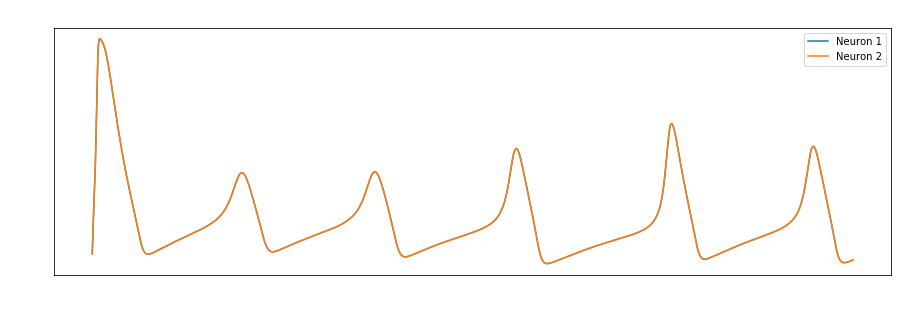

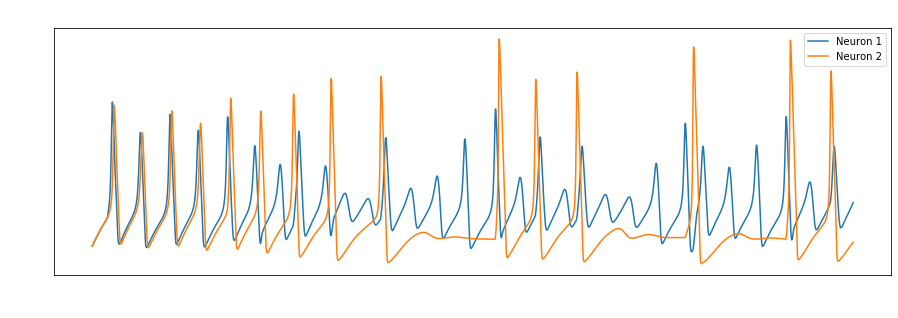

In [58]:
g1 = 0.2
g2 = g1
s1 = 0.006537 #0.002 #
s2 = s1

tvec_start = 0
tvec_end_BURN = 50 #ms
tvec_end = 250
num_points = 5000
#Values to be passed in for generating an applied current:
t_start_CURRENT = 5 #ms
t_end_CURRENT = 7 #ms
amplitude_CURRENT = 0.1 #Amps (per cm^2?)

t = np.linspace(tvec_start,tvec_end_BURN,num_points) #ms
vI_scn_burn = [0,0,0,g1,g2]
#initial condition: V, n, m, h, s
V1 = -58; V2 = -58
n1 = 0.05; n2 = 0.05
m1 = 0.33; m2 = 0.33
h1 = 0.6; h2 = 0.6
x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]

#Burn in run
x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn_burn))
x_scn = np.transpose(x_scn)
plot_vnmh(x_scn,t)

t = np.linspace(tvec_start,tvec_end,num_points) #ms
vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
#initial condition: V, n, m, h, s 
V1 = x_scn[0,-1]
n1 = x_scn[1,-1]
m1 = x_scn[2,-1]
h1 = x_scn[3,-1]
s1 = x_scn[4,-1]

V2 = x_scn[5,-1]
n2 = x_scn[6,-1]
m2 = x_scn[7,-1]
h2 = x_scn[8,-1]
s2 = x_scn[9,-1]

x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]

x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
x_scn = np.transpose(x_scn)
plot_vnmh(x_scn,t)

Iter 0/500: max V1 for g of 0.00000 is 45.165
No 2nd peak found
--------------------------------
Iter 1/500: max V1 for g of 0.00401 is 45.138
No 2nd peak found
--------------------------------
Iter 2/500: max V1 for g of 0.00802 is 45.145
No 2nd peak found
--------------------------------
Iter 3/500: max V1 for g of 0.01202 is 45.149
No 2nd peak found
--------------------------------
Iter 4/500: max V1 for g of 0.01603 is 45.151
No 2nd peak found
--------------------------------
Iter 5/500: max V1 for g of 0.02004 is 45.152
No 2nd peak found
--------------------------------
Iter 6/500: max V1 for g of 0.02405 is 45.152
No 2nd peak found
--------------------------------
Iter 7/500: max V1 for g of 0.02806 is 45.153
No 2nd peak found
--------------------------------
Iter 8/500: max V1 for g of 0.03206 is 45.153
No 2nd peak found
--------------------------------
Iter 9/500: max V1 for g of 0.03607 is 45.153
No 2nd peak found
--------------------------------
Iter 10/500: max V1 for g of 0

Iter 84/500: max V1 for g of 0.33667 is 45.153
No 2nd peak found
--------------------------------
Iter 85/500: max V1 for g of 0.34068 is 45.153
No 2nd peak found
--------------------------------
Iter 86/500: max V1 for g of 0.34469 is 45.153
No 2nd peak found
--------------------------------
Iter 87/500: max V1 for g of 0.34870 is 45.153
No 2nd peak found
--------------------------------
Iter 88/500: max V1 for g of 0.35271 is 45.153
No 2nd peak found
--------------------------------
Iter 89/500: max V1 for g of 0.35671 is 45.153
No 2nd peak found
--------------------------------
Iter 90/500: max V1 for g of 0.36072 is 45.153
No 2nd peak found
--------------------------------
Iter 91/500: max V1 for g of 0.36473 is 45.153
No 2nd peak found
--------------------------------
Iter 92/500: max V1 for g of 0.36874 is 45.153
No 2nd peak found
--------------------------------
Iter 93/500: max V1 for g of 0.37275 is 45.153
No 2nd peak found
--------------------------------
Iter 94/500: max V1 

Iter 168/500: max V1 for g of 0.67335 is 45.153
No 2nd peak found
--------------------------------
Iter 169/500: max V1 for g of 0.67735 is 45.153
No 2nd peak found
--------------------------------
Iter 170/500: max V1 for g of 0.68136 is 45.153
No 2nd peak found
--------------------------------
Iter 171/500: max V1 for g of 0.68537 is 45.153
No 2nd peak found
--------------------------------
Iter 172/500: max V1 for g of 0.68938 is 45.153
No 2nd peak found
--------------------------------
Iter 173/500: max V1 for g of 0.69339 is 45.153
No 2nd peak found
--------------------------------
Iter 174/500: max V1 for g of 0.69739 is 45.153
No 2nd peak found
--------------------------------
Iter 175/500: max V1 for g of 0.70140 is 45.153
No 2nd peak found
--------------------------------
Iter 176/500: max V1 for g of 0.70541 is 45.153
No 2nd peak found
--------------------------------
Iter 177/500: max V1 for g of 0.70942 is 45.153
No 2nd peak found
--------------------------------
Iter 178/5

Iter 253/500: max V1 for g of 1.01002 is 45.153
No 2nd peak found
--------------------------------
Iter 254/500: max V1 for g of 1.01403 is 45.153
No 2nd peak found
--------------------------------
Iter 255/500: max V1 for g of 1.01804 is 45.153
No 2nd peak found
--------------------------------
Iter 256/500: max V1 for g of 1.02204 is 45.153
No 2nd peak found
--------------------------------
Iter 257/500: max V1 for g of 1.02605 is 45.153
No 2nd peak found
--------------------------------
Iter 258/500: max V1 for g of 1.03006 is 45.153
No 2nd peak found
--------------------------------
Iter 259/500: max V1 for g of 1.03407 is 45.153
No 2nd peak found
--------------------------------
Iter 260/500: max V1 for g of 1.03808 is 45.153
No 2nd peak found
--------------------------------
Iter 261/500: max V1 for g of 1.04208 is 45.153
No 2nd peak found
--------------------------------
Iter 262/500: max V1 for g of 1.04609 is 45.153
No 2nd peak found
--------------------------------
Iter 263/5

Iter 336/500: max V1 for g of 1.34269 is 45.153
No 2nd peak found
--------------------------------
Iter 337/500: max V1 for g of 1.34669 is 45.153
No 2nd peak found
--------------------------------
Iter 338/500: max V1 for g of 1.35070 is 45.153
No 2nd peak found
--------------------------------
Iter 339/500: max V1 for g of 1.35471 is 45.153
No 2nd peak found
--------------------------------
Iter 340/500: max V1 for g of 1.35872 is 45.153
No 2nd peak found
--------------------------------
Iter 341/500: max V1 for g of 1.36273 is 45.153
No 2nd peak found
--------------------------------
Iter 342/500: max V1 for g of 1.36673 is 45.153
No 2nd peak found
--------------------------------
Iter 343/500: max V1 for g of 1.37074 is 45.153
No 2nd peak found
--------------------------------
Iter 344/500: max V1 for g of 1.37475 is 45.153
No 2nd peak found
--------------------------------
Iter 345/500: max V1 for g of 1.37876 is 45.153
No 2nd peak found
--------------------------------
Iter 346/5

Iter 419/500: max V1 for g of 1.67535 is 45.153
No 2nd peak found
--------------------------------
Iter 420/500: max V1 for g of 1.67936 is 45.153
No 2nd peak found
--------------------------------
Iter 421/500: max V1 for g of 1.68337 is 45.153
No 2nd peak found
--------------------------------
Iter 422/500: max V1 for g of 1.68737 is 45.153
No 2nd peak found
--------------------------------
Iter 423/500: max V1 for g of 1.69138 is 45.153
No 2nd peak found
--------------------------------
Iter 424/500: max V1 for g of 1.69539 is 45.153
No 2nd peak found
--------------------------------
Iter 425/500: max V1 for g of 1.69940 is 45.153
No 2nd peak found
--------------------------------
Iter 426/500: max V1 for g of 1.70341 is 45.153
No 2nd peak found
--------------------------------
Iter 427/500: max V1 for g of 1.70741 is 45.153
No 2nd peak found
--------------------------------
Iter 428/500: max V1 for g of 1.71142 is 45.153
No 2nd peak found
--------------------------------
Iter 429/5

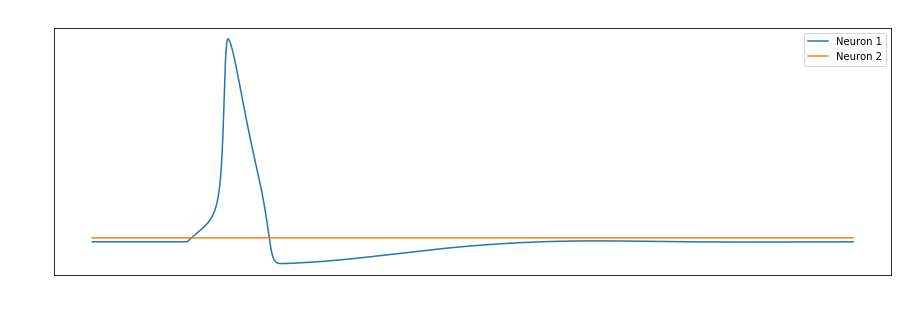

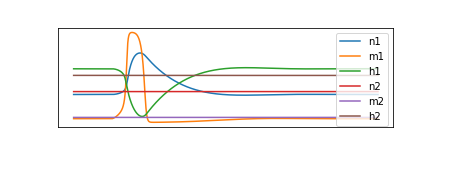

In [17]:
#Procedurally verifying whether we can get periodic APs
found = 0
peak_threshold = 1 #mV #1 instead of 0 in order to provide an offset so it doesn't go crazy for small values of V1
AP_threshold = 30 #Requires that a range of 30 must be met in order to consider the differences in voltage an action potential

tvec_start = 0
tvec_end_BURN = 30 #ms
tvec_end = 40
num_points = 5000
halfway_point = int(np.floor(num_points/2))
#Values to be passed in for generating an applied current:
t_start_CURRENT = 5 #ms
t_end_CURRENT = 7 #ms
amplitude_CURRENT = 0.1 #Amps (per cm^2?)

t = np.linspace(tvec_start,tvec_end_BURN,num_points) #ms

#constants
s1 = 0.006037
s2 = s1
    
gMin = 0
gMax = 1
gPoints = 500

#Actual "function"
gRange = np.linspace(gMin,gMax,gPoints)
for gVal in gRange:
    g1 = gVal
    g2 = g1
    
    vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
    #initial condition: V, n, m, h, s
    V1 = -58; V2 = -58
    n1 = 0.05; n2 = 0.05
    m1 = 0.33; m2 = 0.33
    h1 = 0.6; h2 = 0.6
    x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]
    
    #Burn in run
    x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
    x_scn = np.transpose(x_scn)
    
    t = np.linspace(tvec_start,tvec_end,num_points) #ms
    vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
    #initial condition: V, n, m, h, s
    V1 = x_scn[0,-1] 
    n1 = x_scn[1,-1] 
    m1 = x_scn[2,-1] 
    h1 = x_scn[3,-1] 
    s1 = x_scn[4,-1] 
    V2 = x_scn[5,-1] 
    n2 = x_scn[6,-1] 
    m2 = x_scn[7,-1] 
    h2 = x_scn[8,-1] 
    s2 = x_scn[9,-1] 
    x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]
    
    #Actual run
    x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
    x_scn = np.transpose(x_scn)
    
    #Results
    V1_vec = x_scn[0,:]
    V2_vec = x_scn[5,:]
    diffV = np.subtract(V1_vec,V2_vec)
    arbThresh = 0.005
    if (diffV[0]<arbThresh and diffV[-1]<arbThresh):
        #Then V1 and V2 are the same
        pass
    else:
        print("V1 not equal to V2")
    
    V1_vec = V1_vec.tolist()
    max_val = max(V1_vec)
    min_val = min(V1_vec)
    max_idx = V1_vec.index(max_val)
    my_string = "Iter {my_iter:.0f}/{total}: max V1 for g of {temp_g:.5f} is {max_val:.3f}"
    print(my_string.format(my_iter = gVal/gMax*gPoints, total = gPoints, temp_g = gVal, max_val = max_val))
            
    #See if there a high value (ie above 0 since resting is about -60 mV) in the second half
    if max_idx<halfway_point: #ie does it occur in the first half
        for nextidx, nextV in enumerate(V1_vec[halfway_point:]):
            if (nextV>=peak_threshold) and (max_val-min_val>AP_threshold):
                print("Second spike found at index ", nextidx, "?")
                print("Found value is ", nextV)
                print("Max peak is ", max_val)
                vertIndex = (nextidx+halfway_point+1)/num_points*(tvec_end-tvec_start) #Adjust so that the index is now a time
                plot_vnmh(x_scn,t,vertIndex)
                print("--------------------------------")
                found = 1
                break
    if found:
        print("This should be the minimal g value for which spikes occur")
        break
    
    print("No 2nd peak found")
    print("--------------------------------")
    
if found==0:
    plot_vnmh(x_scn,t)

In [18]:
print(halfway_point)
print(V1_vec[halfway_point])
print(V1_vec[halfway_point+1])
print(V1_vec[halfway_point+10])
print(V1_vec[halfway_point+100])
print(V1_vec[halfway_point+400])

2500
-62.10008519111365
-62.09360707735198
-62.03566912912933
-61.4927784834698
-60.17246533175542
